# **Food Calories Estimation Using Image Processing**
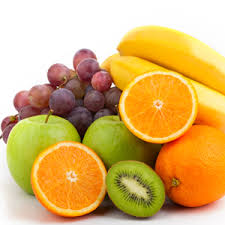

+ ###  Problem
 The problem can be simply stated as, given a set of food images with calibration object thumb with the food name and an unlabeled set of food images from the same group of food, identify food and estimate food volume and calories intake.
+ ### Objectives
 1.	To detect food type by using Convolutional Neural Network (CNN)
 2.	To estimate food weight and calories of food


In [1]:
!pip install tflearn


C:\Users\Lenovo\Downloads\Food-Calories-Estimation-Using-Image-Processing


In [2]:
#image_segment
import cv2
import numpy as np
import os

def getAreaOfFood(img1):
    data=os.path.join(os.getcwd(),"images")
    if os.path.exists(data):
        print('folder exist for images at ',data)
    else:
        os.mkdir(data)
        print('folder created for images at ',data)
        
    cv2.imwrite('{}\\1 original image.jpg'.format(data),img1)
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('{}\\2 original image BGR2GRAY.jpg'.format(data),img)
    img_filt = cv2.medianBlur( img, 5)
    cv2.imwrite('{}\\3 img_filt.jpg'.format(data),img_filt)
    img_th = cv2.adaptiveThreshold(img_filt,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,21,2)
    cv2.imwrite('{}\\4 img_th.jpg'.format(data),img_th)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #make change here


	# find contours. sort. and find the biggest contour. the biggest contour corresponds to the plate and fruit.
    mask = np.zeros(img.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    cv2.imwrite('{}\\5 mask.jpg'.format(data),mask)
    img_bigcontour = cv2.bitwise_and(img1,img1,mask = mask)
    cv2.imwrite('{}\\6 img_bigcontour.jpg'.format(data),img_bigcontour)

	# convert to hsv. otsu threshold in s to remove plate
    hsv_img = cv2.cvtColor(img_bigcontour, cv2.COLOR_BGR2HSV)
    cv2.imwrite('{}\\7 hsv_img.jpg'.format(data),hsv_img)
    h,s,v = cv2.split(hsv_img)
    mask_plate = cv2.inRange(hsv_img, np.array([0,0,50]), np.array([200,90,250]))
    cv2.imwrite('{}\\8 mask_plate.jpg'.format(data),mask_plate)
    mask_not_plate = cv2.bitwise_not(mask_plate)
    cv2.imwrite('{}\\9 mask_not_plate.jpg'.format(data),mask_not_plate)
    fruit_skin = cv2.bitwise_and(img_bigcontour,img_bigcontour,mask = mask_not_plate)
    cv2.imwrite('{}\\10 fruit_skin.jpg'.format(data),fruit_skin)

	#convert to hsv to detect and remove skin pixels
    hsv_img = cv2.cvtColor(fruit_skin, cv2.COLOR_BGR2HSV)
    cv2.imwrite('{}\\11 hsv_img.jpg'.format(data),hsv_img)
    skin = cv2.inRange(hsv_img, np.array([0,10,60]), np.array([10,160,255])) #Scalar(0, 10, 60), Scalar(20, 150, 255)
    cv2.imwrite('{}\\12 skin.jpg'.format(data),skin)
    not_skin = cv2.bitwise_not(skin); #invert skin and black
    cv2.imwrite('{}\\13 not_skin.jpg'.format(data),not_skin)
    fruit = cv2.bitwise_and(fruit_skin,fruit_skin,mask = not_skin) #get only fruit pixels
    cv2.imwrite('{}\\14 fruit.jpg'.format(data),fruit)
    
    fruit_bw = cv2.cvtColor(fruit, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('{}\\15 fruit_bw.jpg'.format(data),fruit_bw)
    fruit_bin = cv2.inRange(fruit_bw, 10, 255) #binary of fruit
    cv2.imwrite('{}\\16 fruit_bw.jpg'.format(data),fruit_bin)

	#erode before finding contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    erode_fruit = cv2.erode(fruit_bin,kernel,iterations = 1)
    cv2.imwrite('{}\\17 erode_fruit.jpg'.format(data),erode_fruit)

	#find largest contour since that will be the fruit
    img_th = cv2.adaptiveThreshold(erode_fruit,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    cv2.imwrite('{}\\18 img_th.jpg'.format(data),img_th)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_fruit = np.zeros(fruit_bin.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask_fruit, [largest_areas[-2]], 0, (255,255,255), -1)
    cv2.imwrite('{}\\19 mask_fruit.jpg'.format(data),mask_fruit)

	#dilate now
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask_fruit2 = cv2.dilate(mask_fruit,kernel2,iterations = 1)
    cv2.imwrite('{}\\20 mask_fruit2.jpg'.format(data),mask_fruit2)
    fruit_final = cv2.bitwise_and(img1,img1,mask = mask_fruit2)
    cv2.imwrite('{}\\21 fruit_final.jpg'.format(data),fruit_final)
    
	#find area of fruit
    img_th = cv2.adaptiveThreshold(mask_fruit2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    cv2.imwrite('{}\\22 img_th.jpg'.format(data),img_th)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    fruit_contour = largest_areas[-2]
    fruit_area = cv2.contourArea(fruit_contour)

	
	#finding the area of skin. find area of biggest contour
    skin2 = skin - mask_fruit2
    cv2.imwrite('{}\\23 skin2.jpg'.format(data),skin2)
	#erode before finding contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    skin_e = cv2.erode(skin2,kernel,iterations = 1)
    cv2.imwrite('{}\\24 skin_e .jpg'.format(data),skin_e )
    img_th = cv2.adaptiveThreshold(skin_e,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    cv2.imwrite('{}\\25 img_th.jpg'.format(data),img_th)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_skin = np.zeros(skin.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask_skin, [largest_areas[-2]], 0, (255,255,255), -1)
    cv2.imwrite('{}\\26 mask_skin.jpg'.format(data),mask_skin)
    
    
    skin_rect = cv2.minAreaRect(largest_areas[-2])
    box = cv2.boxPoints(skin_rect)
    box = np.int0(box)
    mask_skin2 = np.zeros(skin.shape, np.uint8)
    cv2.drawContours(mask_skin2,[box],0,(255,255,255), -1)
    cv2.imwrite('{}\\27 mask_skin2.jpg'.format(data),mask_skin2)
    
    pix_height = max(skin_rect[1])
    pix_to_cm_multiplier = 5.0/pix_height
    skin_area = cv2.contourArea(box)
    
    
    return fruit_area,fruit_bin ,fruit_final,skin_area, fruit_contour, pix_to_cm_multiplier

In [3]:
#calories
import cv2
import numpy as np
#density - gram / cm^3
density_dict = { 1:0.609, 2:0.94, 3:0.641,  4:0.641,5:0.513, 6:0.482,7:0.481}
#kcal
calorie_dict = { 1:52, 2:89,  3:41,4:16,5:40,6:47,7:18 }
#skin of photo to real multiplier
skin_multiplier = 5*2.3

def getCalorie(label, volume): #volume in cm^3
	calorie = calorie_dict[int(label)]
	density = density_dict[int(label)]
	mass = volume*density*1.0
	calorie_tot = (calorie/100.0)*mass
	return mass, calorie_tot, calorie #calorie per 100 grams

def getVolume(label, area, skin_area, pix_to_cm_multiplier, fruit_contour):
	area_fruit = (area/skin_area)*skin_multiplier #area in cm^2
	label = int(label)
	volume = 100
	if label == 1 or label == 5 or label == 7 or label == 6 : #sphere-apple,tomato,orange,kiwi,onion
		radius = np.sqrt(area_fruit/np.pi)
		volume = (4/3)*np.pi*radius*radius*radius
		#print (area_fruit, radius, volume, skin_area)
	
	if label == 2 or label == 4 or (label == 3 and area_fruit > 30): #cylinder like banana, cucumber, carrot
		fruit_rect = cv2.minAreaRect(fruit_contour)
		height = max(fruit_rect[1])*pix_to_cm_multiplier
		radius = area_fruit/(2.0*height)
		volume = np.pi*radius*radius*height
		
	if (label==4 and area_fruit < 30) : # carrot
		volume = area_fruit*0.5 #assuming width = 0.5 cm
	
	return volume

def calories(result,img):
    img_path =img # "C:/Users/M Sc-2/Desktop/dataset/FooD/"+str(j)+"_"+str(i)+".jpg"
    fruit_areas,final_f,areaod,skin_areas, fruit_contours, pix_cm = getAreaOfFood(img_path)
    volume = getVolume(result, fruit_areas, skin_areas, pix_cm, fruit_contours)
    mass, cal, cal_100 = getCalorie(result, volume)
    fruit_volumes=volume
    fruit_calories=cal
    fruit_calories_100grams=cal_100
    fruit_mass=mass
    #print("\nfruit_volumes",fruit_volumes,"\nfruit_calories",fruit_calories,"\nruit_calories_100grams",fruit_calories_100grams,"\nfruit_mass",fruit_mass)
    return fruit_calories

In [4]:
#cnn_model
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
import random

def get_model(IMG_SIZE,no_of_fruits,LR):
	try:
		tf.reset_default_graph()
	except:
		print("tensorflow")
	convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

	convnet = conv_2d(convnet, 32, 5, activation='relu')

	convnet = max_pool_2d(convnet, 5)

	convnet = conv_2d(convnet, 64, 5, activation='relu')

	convnet = max_pool_2d(convnet, 5)

	convnet = conv_2d(convnet, 128, 5, activation='relu')
	convnet = max_pool_2d(convnet, 5)

	convnet = conv_2d(convnet, 64, 5, activation='relu')
	convnet = max_pool_2d(convnet, 5)


	convnet = conv_2d(convnet, 32, 5, activation='relu')
	convnet = max_pool_2d(convnet, 5)

	convnet = fully_connected(convnet, 1024, activation='relu')
	convnet = dropout(convnet, 0.8)

	convnet = fully_connected(convnet, no_of_fruits, activation='softmax')
	convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

	model = tflearn.DNN(convnet, tensorboard_dir='log')

	return model

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [5]:
#demo
import os  
import cv2
import numpy as np

IMG_SIZE = 400
LR = 1e-3
no_of_fruits=7

MODEL_NAME = 'Fruits_dectector-{}-{}.model'.format(LR, '5conv-basic')

model_save_at=os.path.join("model",MODEL_NAME)

model=get_model(IMG_SIZE,no_of_fruits,LR)

model.load(model_save_at)
labels=list(np.load('labels.npy'))



tensorflow
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\Downloads\Food-Calories-Estimation-Using-Image-Processing\model\Fruits_dectector-0.001-5conv-basic.model


In [6]:
%pip install pytest-shutil
import shutil
import requests

Note: you may need to restart the kernel to use updated packages.


In [7]:
result1 = "def"

def test(filename):
#     test_data='test_image.JPG'
    test_data = filename 
    img=cv2.imread(test_data)
    img1=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    model_out=model.predict([img1])
    result=np.argmax(model_out)
    name=labels[result]
    name="Apple" if name in ["Orange","Onion","kiwi","Tomato"] else name
    name="Banana" if name in ["Carrot","Cucumber"] else name
    cal=round(calories(result+1,img),2)
    cal = random.randint(85, 110) if cal else cal
    
    global result1
    result1 = name + ": " + str(cal) +"cal"
    print("2: ", result)

#     import matplotlib.pyplot as plt
#     plt.imshow(img)
#     plt.title('{}({}kcal)'.format(name,cal))
#     plt.axis('off')
#     plt.savefig("newfile.png")
#     return send_file(filename="newfile.png")

In [8]:
def downloadImgAndTest(url):
    res = requests.get(url, stream = True)
    with open("C:/Users/Lenovo/Downloads/Food-Calories-Estimation-Using-Image-Processing/test_image.JPG", 'wb') as f:
        shutil.copyfileobj(res.raw, f)
    test("test_image.JPG")

In [9]:
from flask import Flask, send_file, request
import json
import threading

In [10]:
app = Flask(__name__)

In [11]:
@app.route('/')
def home():
#     download_file("https://www.dropbox.com/s/ec79hw48vpqypda/banana.jpeg?")
#     return test()
    return "home"

@app.route('/test_post', methods=['POST', 'GET'])
def test_post():
    payload = request.get_json()
    # process then do this
    print(payload)
    thread = threading.Thread(target=downloadImgAndTest(payload['sometext']))
    thread.start()
    print(result1)
    return json.dumps({'result1':result1})

@app.route('/test')
def testServer():
    return "200 SERVER OK"

In [ ]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


{'sometext': 'https://www.dropbox.com/s/swk13j8d44ohwgg/IMG_7441.jpg?dl=1'}
folder exist for images at  C:\Users\Lenovo\Downloads\Food-Calories-Estimation-Using-Image-Processing\images


127.0.0.1 - - [16/Oct/2022 03:06:50] "POST /test_post HTTP/1.1" 200 -


2:  5
Apple: 101cal


127.0.0.1 - - [16/Oct/2022 04:27:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Oct/2022 04:27:56] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Oct/2022 04:28:01] "GET /test HTTP/1.1" 200 -
127.0.0.1 - - [16/Oct/2022 05:40:21] "GET /test HTTP/1.1" 200 -
127.0.0.1 - - [16/Oct/2022 05:40:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Oct/2022 05:40:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Oct/2022 05:40:33] "GET /hi HTTP/1.1" 404 -
127.0.0.1 - - [16/Oct/2022 05:40:33] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Oct/2022 05:40:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Oct/2022 05:40:37] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
%pip install ngrok

In [ ]:
%ngrok